# GP Method Comparison

Compare different GP training approaches focusing on:
- Training time cost for small number of simulations in different data type (kSZ, deltaSigma)
- Prediction accuracy (test_plot style) for same number of testing data
- Save all plots to save_dir
- Load pre-trained models for Methods 1-3 from trained_gp_models/GP_comparison_090625
- Use conditional_gp training for Method 4 with different kernel types

In [9]:
filterType= 'CAP'  #'dsigma' #'CAP' 
ptype='gas' #'total' #'gas'
n_sims = 20  # Number of simulations to train
plot_mode = 'train'

PRETRAIN_AVAILABLE = False
# Path to pre-trained models
pretrained_dir = "trained_gp_models/GP_comparison_090625_CAP"
print(f"Loading pre-trained models from: {pretrained_dir}")

Loading pre-trained models from: trained_gp_models/GP_comparison_090625_CAP


In [2]:
import jax
import numpy as np
import matplotlib.pyplot as plt
import time
import pickle
import os
from datetime import datetime

jax.config.update("jax_enable_x64", True)
np.random.seed(42)

# Setup save directory
save_dir = f"trained_gp_models/GP_comparison_{datetime.now().strftime('%m%d%y')}_{filterType}_k<10"
os.makedirs(save_dir, exist_ok=True)
print(f"Results will be saved to: {save_dir}")


/global/u1/l/lindajin/virtualenvs/env1/lib/python3.11/site-packages/jaxlib/plugin_support.py:71: RuntimeWarning: JAX plugin jax_cuda12_plugin version 0.6.1 is installed, but it is not compatible with the installed jaxlib version 0.7.1, so it will not be used.
  warnings.warn(


Results will be saved to: trained_gp_models/GP_comparison_090925_CAP_k<10


In [3]:
# Import modules
import importlib
import src.data.profile_loader
import src.models.gp_trainer_one 
importlib.reload(src.data.profile_loader) 
from src.data.sim_dataloader import prepare_gp_training_data
from src.models.gp_trainer_one import *

try:
    from src.models.kernels import *
    IMPROVED_AVAILABLE = True
    print("✅ Improved trainer available")
except ImportError:
    IMPROVED_AVAILABLE = False
    print("❌ Improved trainer not available")

JAX devices: [CpuDevice(id=0)]
Using device: TFRT_CPU_0
✅ Improved trainer available


In [4]:
# Load data
sim_indices_train = np.load('data/sparse_sampling_train_indices_random.npy')  
sim_indices_test = np.load('data/sparse_sampling_test_indices_random.npy')[:n_sims]  # Use subset for testing
sim_subset = sim_indices_train[:n_sims]  # Same subset used in original training

print(f"Training: {len(sim_subset)}/{len(sim_indices_train)} sims, Testing: {len(sim_indices_test)} sims")

# Load training data for predictions
X_train, y_train, r_bins, k_bins = prepare_gp_training_data(sim_subset, filterType, ptype)
print(f"Train data {sim_subset}: X={X_train.shape}, y={y_train.shape}")

# Load test data
if plot_mode == 'test':
    X_test, y_test, _, _ = prepare_gp_training_data(sim_indices_test, filterType, ptype)
    print(f"Test data {sim_indices_test}: X={X_test.shape}, y={y_test.shape}")
else:
    X_test = X_train
    y_test = y_train

Training: 20/204 sims, Testing: 20 sims
Getting gas profiles with CAP filter for 20 simulations...


/tmp/ipykernel_1390963/3504434877.py:9: DeprecationWarning: prepare_gp_training_data is deprecated. Use SimulationDataLoader instead.
  X_train, y_train, r_bins, k_bins = prepare_gp_training_data(sim_subset, filterType, ptype)


Finished getting profiles in 1360 halos.
Profiles shape: (1360, 21), Mass shape: (1360,), Params shape: (1360, 35), PkRatio shape: (1360, 79)
Train data [ 3 10 23 25 30 31 39 44 54 55 59 60 63 66 67 70 72 76 86 88]: X=(1360, 115), y=(1360, 21)


## Method 1: Load Pre-trained NN+GP Model

In [5]:
print("=== Method 1: Loading Pre-trained NN+GP Model ===")
start_time = time.time()
if PRETRAIN_AVAILABLE:
    # Load pre-trained parameters
    with open(os.path.join(pretrained_dir, "best_params_nn_list.pkl"), "rb") as f:
        best_params_nn = pickle.load(f)
    with open(os.path.join(pretrained_dir, "model_info_nn_list.pkl"), "rb") as f:
        model_info_nn = pickle.load(f)
else:
    gp_models_nn, best_params_nn, model_info_nn = train_NN_gp(
    sim_subset, filterType=filterType, ptype=ptype, save=False
)
    with open(os.path.join(pretrained_dir, "best_params_nn_list.pkl"), "wb") as f:
        pickle.dump(best_params_nn, f) 
    with open(os.path.join(pretrained_dir, "model_info_nn_list.pkl"), "wb") as f:
        pickle.dump(model_info_nn, f) 

nn_train_time = time.time() - start_time
print(f"NN+GP model training/loading time: {nn_train_time:.3f}s")
print(f"Loaded {len(best_params_nn)} trained NN+GP models")

=== Method 1: Loading Pre-trained NN+GP Model ===
Getting gas profiles with CAP filter for 20 simulations...
Finished getting profiles in 1360 halos.
Profiles shape: (1360, 21), Mass shape: (1360,), Params shape: (1360, 35), PkRatio shape: (1360, 79)


Training GP for each r_bin:   0%|          | 0/21 [00:00<?, ?it/s]

Start Adamw training for r_bin 0: Initial loss = 43101.234375


Training GP for each r_bin:   5%|▍         | 1/21 [02:30<50:02, 150.13s/it, Step=1900, Loss=5134.885254, Best=5134.885254]

r_bin 0 in 147.05s: Final loss = 5088.820312
Start Adamw training for r_bin 1: Initial loss = 3737.756103515625


Training GP for each r_bin:  10%|▉         | 2/21 [04:56<46:53, 148.06s/it, Step=1900, Loss=2770.023193, Best=2770.023193]

r_bin 1 in 145.80s: Final loss = 2767.135254
Start Adamw training for r_bin 2: Initial loss = 4206.080078125


Training GP for each r_bin:  14%|█▍        | 3/21 [07:21<44:01, 146.76s/it, Step=1900, Loss=2857.984375, Best=2852.502930]

r_bin 2 in 144.41s: Final loss = 2849.916016
Start Adamw training for r_bin 3: Initial loss = 7921.83056640625


Training GP for each r_bin:  19%|█▉        | 4/21 [09:46<41:23, 146.06s/it, Step=1900, Loss=3532.984863, Best=3532.984863]

r_bin 3 in 144.18s: Final loss = 3530.678223
Start Adamw training for r_bin 4: Initial loss = 16318.47265625


Training GP for each r_bin:  24%|██▍       | 5/21 [12:11<38:45, 145.37s/it, Step=1900, Loss=4102.902344, Best=4102.902344] 

r_bin 4 in 143.34s: Final loss = 4097.268066
Start Adamw training for r_bin 5: Initial loss = 20988.53125


Training GP for each r_bin:  29%|██▊       | 6/21 [14:35<36:13, 144.92s/it, Step=1900, Loss=4332.513672, Best=4332.513672] 

r_bin 5 in 143.24s: Final loss = 4309.139648
Start Adamw training for r_bin 6: Initial loss = 26893.072265625


Training GP for each r_bin:  33%|███▎      | 7/21 [16:59<33:44, 144.58s/it, Step=1900, Loss=4616.605469, Best=4616.605469] 

r_bin 6 in 143.10s: Final loss = 4561.578613
Start Adamw training for r_bin 7: Initial loss = 33854.0234375


Training GP for each r_bin:  38%|███▊      | 8/21 [19:23<31:18, 144.54s/it, Step=1900, Loss=4950.353027, Best=4950.353027] 

r_bin 7 in 143.63s: Final loss = 4859.115723
Start Adamw training for r_bin 8: Initial loss = 36933.8984375


Training GP for each r_bin:  43%|████▎     | 9/21 [21:48<28:57, 144.82s/it, Step=1900, Loss=5116.879395, Best=5116.879395] 

r_bin 8 in 144.69s: Final loss = 4994.931641
Start Adamw training for r_bin 9: Initial loss = 42198.09375


Training GP for each r_bin:  48%|████▊     | 10/21 [24:14<26:36, 145.09s/it, Step=1900, Loss=5625.724121, Best=5625.724121]

r_bin 9 in 144.92s: Final loss = 5336.032715
Start Adamw training for r_bin 10: Initial loss = 47234.984375


Training GP for each r_bin:  52%|█████▏    | 11/21 [26:39<24:08, 144.88s/it, Step=1900, Loss=5830.756836, Best=5830.756836] 

r_bin 10 in 143.64s: Final loss = 5684.688965
Start Adamw training for r_bin 11: Initial loss = 50987.0625


Training GP for each r_bin:  57%|█████▋    | 12/21 [29:03<21:42, 144.77s/it, Step=1900, Loss=5841.689941, Best=5841.689941] 

r_bin 11 in 143.74s: Final loss = 5733.631348
Start Adamw training for r_bin 12: Initial loss = 56083.64453125


Training GP for each r_bin:  62%|██████▏   | 13/21 [31:29<19:20, 145.04s/it, Step=1900, Loss=5984.436523, Best=5984.436523] 

r_bin 12 in 144.86s: Final loss = 5855.649414
Start Adamw training for r_bin 13: Initial loss = 57272.31640625


Training GP for each r_bin:  67%|██████▋   | 14/21 [33:52<16:51, 144.48s/it, Step=1900, Loss=5950.422852, Best=5950.422852] 

r_bin 13 in 142.45s: Final loss = 5825.278320
Start Adamw training for r_bin 14: Initial loss = 61194.2578125


Training GP for each r_bin:  71%|███████▏  | 15/21 [36:16<14:25, 144.28s/it, Step=1900, Loss=6045.498535, Best=6045.498535] 

r_bin 14 in 143.05s: Final loss = 5914.575684
Start Adamw training for r_bin 15: Initial loss = 68179.3984375


Training GP for each r_bin:  76%|███████▌  | 16/21 [38:40<12:01, 144.28s/it, Step=1900, Loss=6001.992188, Best=6001.992188] 

r_bin 15 in 143.52s: Final loss = 5879.906250
Start Adamw training for r_bin 16: Initial loss = 68522.9765625


Training GP for each r_bin:  81%|████████  | 17/21 [41:04<09:37, 144.26s/it, Step=1900, Loss=6001.623047, Best=6001.623047] 

r_bin 16 in 143.20s: Final loss = 5879.329102
Start Adamw training for r_bin 17: Initial loss = 68744.75


Training GP for each r_bin:  86%|████████▌ | 18/21 [43:29<07:12, 144.29s/it, Step=1900, Loss=6016.256836, Best=6016.256836] 

r_bin 17 in 143.57s: Final loss = 5896.012695
Start Adamw training for r_bin 18: Initial loss = 70426.390625


Training GP for each r_bin:  90%|█████████ | 19/21 [45:52<04:48, 144.02s/it, Step=1900, Loss=6098.518066, Best=6098.518066] 

r_bin 18 in 142.58s: Final loss = 5969.211914
Start Adamw training for r_bin 19: Initial loss = 75813.671875


Training GP for each r_bin:  95%|█████████▌| 20/21 [48:17<02:24, 144.29s/it, Step=1900, Loss=6121.735352, Best=6121.735352] 

r_bin 19 in 144.17s: Final loss = 5990.626953
Start Adamw training for r_bin 20: Initial loss = 79622.671875


Training GP for each r_bin: 100%|██████████| 21/21 [50:42<00:00, 144.88s/it, Step=1900, Loss=6151.961914, Best=6151.961914] 

r_bin 20 in 144.34s: Final loss = 6019.062500
NN+GP model training/loading time: 3042.665s
Loaded 21 trained NN+GP models


In [6]:
# Generate NN+GP predictions
print("Generating NN+GP predictions...")
pred_start = time.time()

pred_means_nn = []
pred_vars_nn = []
model = build_NN_gp()

for i in range(len(best_params_nn)):
    cond_gp = model.apply(best_params_nn[i], X_train, y_train[:,i], X_test)[1]
    pred_means_nn.append(cond_gp.mean)
    pred_vars_nn.append(cond_gp.variance)

pred_means_nn = np.array(pred_means_nn)
pred_vars_nn = np.array(pred_vars_nn)
nn_pred_time = time.time() - pred_start
print(f"NN+GP predictions shape: {pred_means_nn.shape} (generated in {nn_pred_time:.2f}s)")

Generating NN+GP predictions...
NN+GP predictions shape: (21, 1360) (generated in 10.64s)


## Method 2: Load Pre-trained Hierarchical GP Model

=== Method 2: Loading Pre-trained Hierarchical GP Model ===
Getting gas profiles with CAP filter for 20 simulations...
Finished getting profiles in 1360 halos.
Profiles shape: (1360, 21), Mass shape: (1360,), Params shape: (1360, 35), PkRatio shape: (1360, 79)


Training GP models: 100%|██████████| 21/21 [12:02<00:00, 34.42s/it, bin=20, loss=5382.9590]


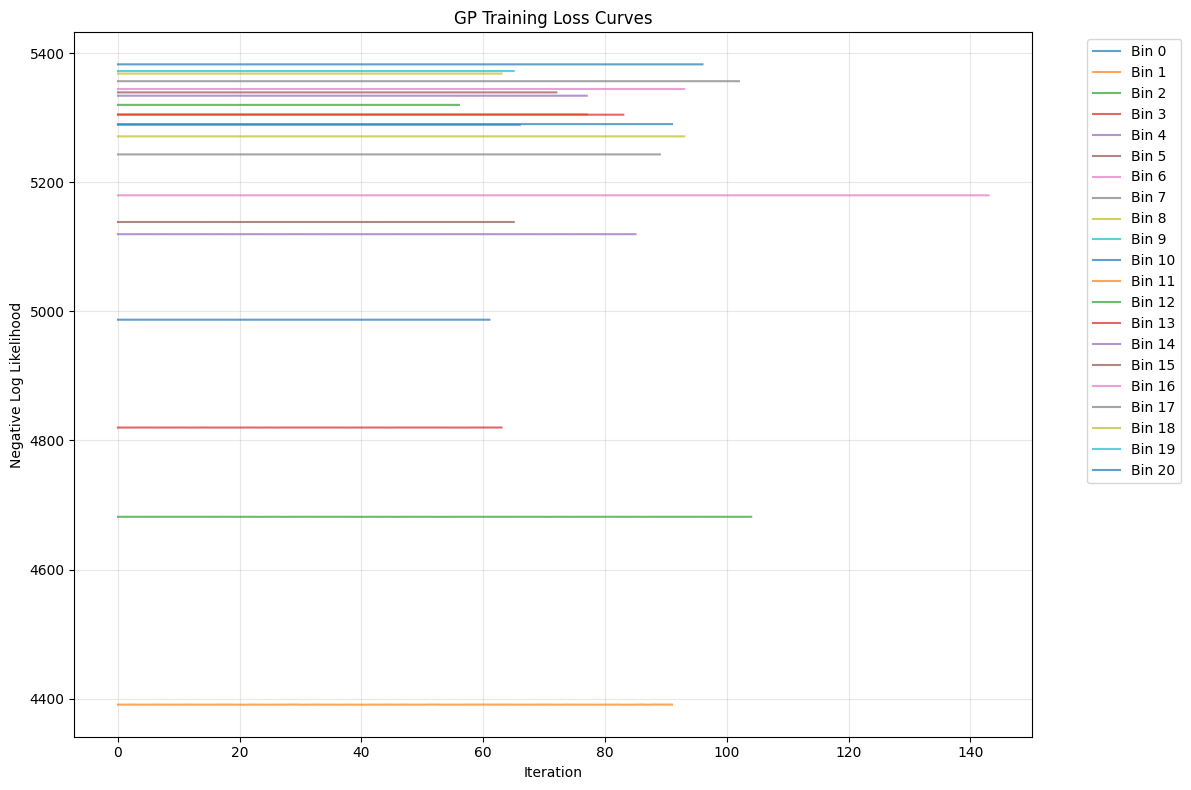

Hierarchical GP model loading time: 725.998s
Loaded 21 trained Hierarchical GP models


In [10]:
print("=== Method 2: Loading Pre-trained Hierarchical GP Model ===")
start_time = time.time()
if PRETRAIN_AVAILABLE:
    # Load pre-trained parameters
    with open(os.path.join(pretrained_dir, "best_params_hier_list.pkl"), "rb") as f:
        best_params_hier = pickle.load(f)
    with open(os.path.join(pretrained_dir, "model_info_hier_list.pkl"), "rb") as f:
        model_info_hier = pickle.load(f)
else:
    gp_models_hier, best_params_hier, model_info_hier = train_conditional_gp(
    sim_subset, build_hierarchical_gp, maxiter=1000,
    filterType=filterType, ptype=ptype, save=False)
    with open(os.path.join(pretrained_dir, "best_params_hier_list.pkl"), "wb") as f:
        pickle.dump(best_params_hier, f) 
    with open(os.path.join(pretrained_dir, "model_info_hier_list.pkl"), "wb") as f:
        pickle.dump(model_info_hier, f) 
hier_train_time = time.time() - start_time
print(f"Hierarchical GP model loading time: {hier_train_time:.3f}s")
print(f"Loaded {len(best_params_hier)} trained Hierarchical GP models")

In [11]:
# Generate Hierarchical GP predictions
print("Generating Hierarchical GP predictions...")
pred_start = time.time()

# Rebuild GP models from saved parameters
gp_models_hier = []
for i in range(len(best_params_hier)):
    gp_model = build_hierarchical_gp(best_params_hier[i], X_train)
    gp_models_hier.append(gp_model)

pred_means_hier = []
pred_vars_hier = []

for i, gp_model in enumerate(gp_models_hier):
    _, cond_gp = gp_model.condition(y_train[:, i], X_test)
    pred_means_hier.append(cond_gp.mean)
    pred_vars_hier.append(cond_gp.variance)

pred_means_hier = np.array(pred_means_hier)
pred_vars_hier = np.array(pred_vars_hier)
hier_pred_time = time.time() - pred_start
print(f"Hierarchical GP predictions shape: {pred_means_hier.shape} (generated in {hier_pred_time:.2f}s)")

Generating Hierarchical GP predictions...
Hierarchical GP predictions shape: (21, 1360) (generated in 14.40s)


## Method 3: Training with Different Kernel Types

In [12]:
import importlib
from src.models.kernels import test_multiscale_training, test_physics_informed_training, test_robust_training
IMPROVED_AVAILABLE=False
if IMPROVED_AVAILABLE:
    print("=== Method 4: Training with Different Kernels ===")
    
    # Define kernel types to compare
    kernel_types = ['multiscale', 'physics_informed', 'robust']
    kernel_funcs = [test_robust_training, test_multiscale_training, test_physics_informed_training]
    kernel_results = {}

    for kernel_name, kernel_func in zip(kernel_types,kernel_funcs):
        start_time = time.time()
        if PRETRAIN_AVAILABLE:
            print(f"\nLoading pretrained {kernel_name} kernel...")
            try:
                # Load pretrained model
                with open(os.path.join(pretrained_dir, f"best_params_{kernel_name}_list.pkl"), "rb") as f:
                    best_params = pickle.load(f)
                with open(os.path.join(pretrained_dir, f"model_info_{kernel_name}_list.pkl"), "rb") as f:
                    model_info = pickle.load(f)
                gp_models = [build_hierarchical_gp(best_params[i], X_train) for i in range(len(best_params))]
            except Exception as e:
                print(f"❌ Loading pretrained {kernel_name} kernel failed: {e}")
        else:
            print(f"\nTraining with {kernel_name} kernel...")
            try:
                # Train with current kernel
                gp_models, best_params, model_info = kernel_func(
                    sim_subset
                )
                with open(os.path.join(save_dir, f"best_params_{kernel_name}_list.pkl"), "wb") as f:
                 pickle.dump(best_params, f)
                with open(os.path.join(save_dir, f"model_info_{kernel_name}_list.pkl"), "wb") as f:
                 pickle.dump(model_info, f)
            except Exception as e:
                print(f"❌ {kernel_name} kernel failed: {e}")
                kernel_results[kernel_name] = {'error': str(e)}
                
        train_time = time.time() - start_time
        print(f"{kernel_name} kernel loading/training time: {train_time:.1f}s")
        
        # Generate predictions
        pred_start = time.time()
        pred_means = []
        pred_vars = []
        
        for i, gp_model in enumerate(gp_models):
            _, cond_gp = gp_model.condition(y_train[:, i], X_test)
            pred_means.append(cond_gp.mean)
            pred_vars.append(cond_gp.variance)
        
        pred_means = np.array(pred_means)
        pred_vars = np.array(pred_vars)
        pred_time = time.time() - pred_start
        
        kernel_results[kernel_name] = {
            'train_time': train_time,
            'pred_time': pred_time,
            'pred_means': pred_means,
            'pred_vars': pred_vars,
            'models': gp_models,
            'params': best_params
        }
        
        print(f"{kernel_name} predictions shape: {pred_means.shape} (generated in {pred_time:.2f}s)")
            

    
    print(f"\n✅ Completed training with {len([k for k, v in kernel_results.items() if 'error' not in v])} kernel types")
    
else:
    print("Method 4 skipped - improved trainer not available")
    kernel_results = {}

Method 4 skipped - improved trainer not available


## Training/Loading Time Comparison

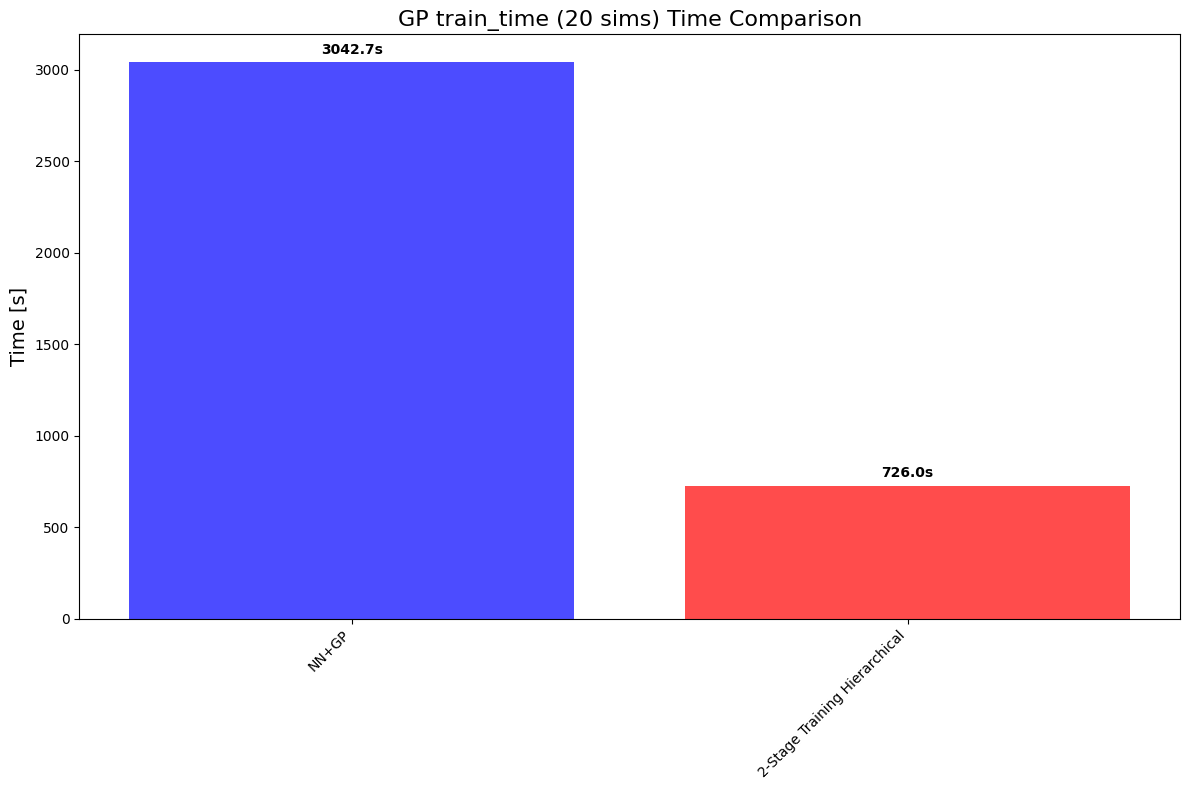

Time Summary:
  NN+GP: 3042.7s
  2-Stage Training Hierarchical: 726.0s


In [13]:
# Compile all timing results
timetype = 'train_time'
methods = ['NN+GP', '2-Stage Training Hierarchical']
times = [eval(f'nn_{timetype}'), eval(f'hier_{timetype}')]
colors = ['blue', 'red']
# Add kernel training times
if kernel_results:
    for kernel_name, results in kernel_results.items():
        if 'error' not in results:
            methods.append(f'{kernel_name}')
            times.append(results[timetype])
            colors.append(['orange', 'purple', 'brown', 'pink'][len(methods)-4])
# Plot comparison
plt.figure(figsize=(12, 8))
bars = plt.bar(methods, times, color=colors, alpha=0.7)
plt.ylabel('Time [s]', fontsize=14)
plt.title(f'GP {timetype} ({n_sims} sims) Time Comparison', fontsize=16)
plt.xticks(rotation=45, ha='right')
# Add value labels on bars
for bar, time_val in zip(bars, times):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + max(times)*0.01,
    f'{time_val:.3f}s' if time_val < 1 else f'{time_val:.1f}s', 
    ha='center', va='bottom', fontweight='bold')
plt.tight_layout()
plt.savefig(f'{save_dir}/{timetype}_comparison.png', dpi=150, bbox_inches='tight')
plt.show()
print("Time Summary:")
for method, time_val in zip(methods, times):
    print(f"  {method}: {time_val:.3f}s" if time_val < 1 else f"  {method}: {time_val:.1f}s")


## Test Plot Comparison

In [14]:
# Compute ground truth statistics
upper = np.quantile(y_test, 0.25, axis=0)
lower = np.quantile(y_test, 0.75, axis=0)
median = np.median(y_test, axis=0)
yerr_lower = np.abs(median - lower)
yerr_upper = np.abs(upper - median)
yerr_truth = [yerr_lower, yerr_upper]

print(f"Ground truth computed for {len(r_bins)} radius bins")

Ground truth computed for 21 radius bins


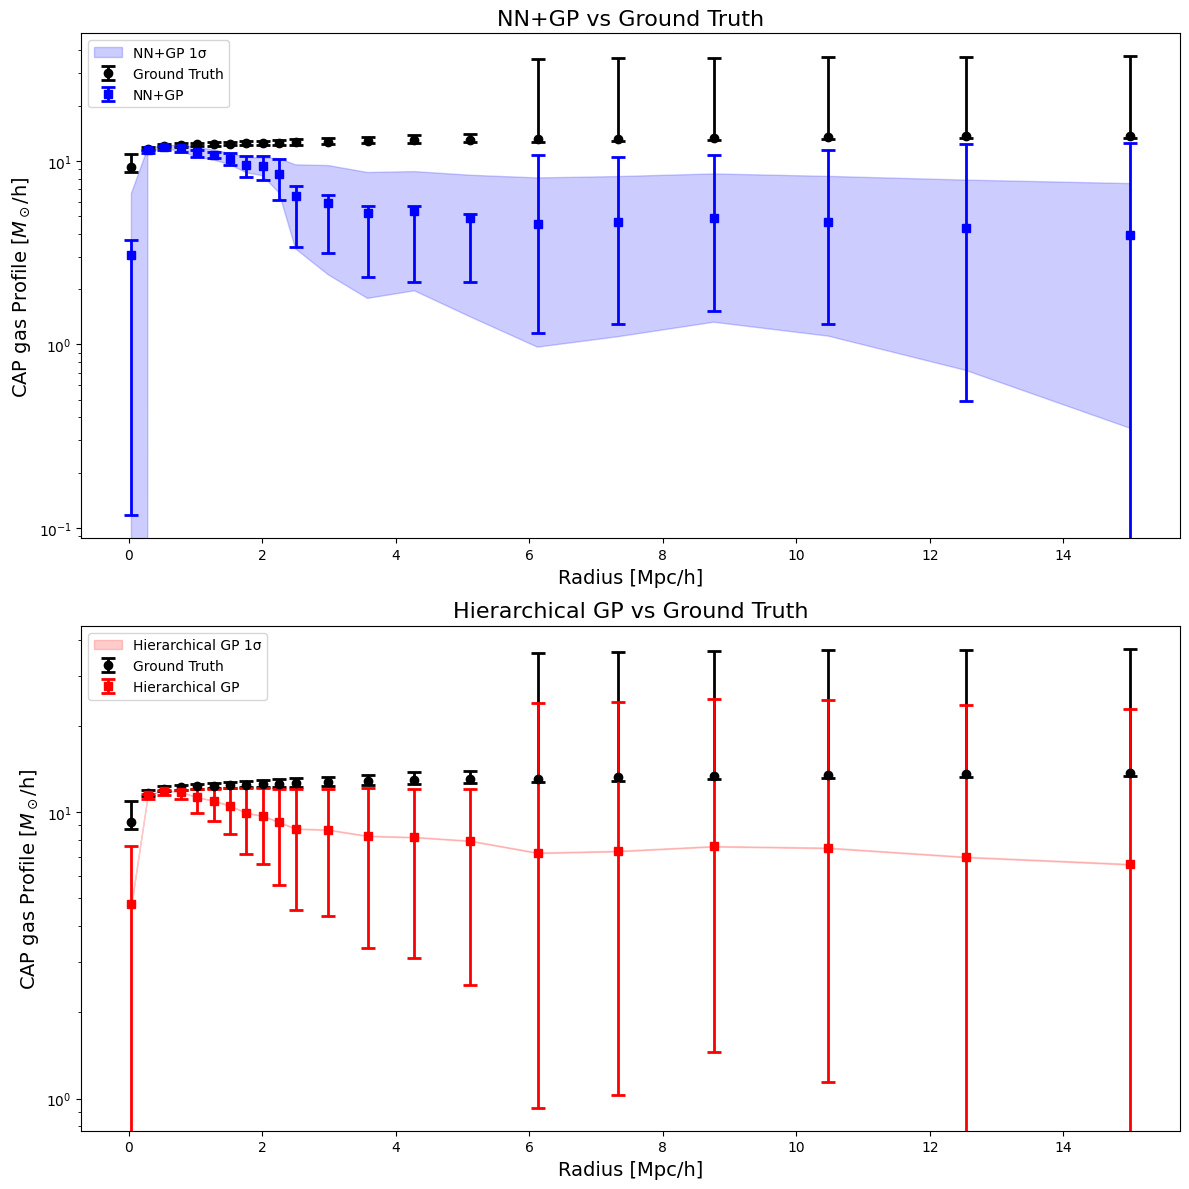

In [15]:
# Create comprehensive comparison plot
n_plots = 2 + len([k for k, v in kernel_results.items() if 'error' not in v])
fig, axes = plt.subplots(n_plots, 1, figsize=(12, 6*n_plots))
if n_plots == 1:
    axes = [axes]

plot_idx = 0

# Helper function to plot method comparison
def plot_method_comparison(ax, pred_means, pred_vars, method_name, color):
    # Ground truth
    ax.errorbar(r_bins, median, yerr=yerr_truth, fmt='o', capsize=5, capthick=2, 
                linewidth=2, markersize=6, color='black', label='Ground Truth')
    
    # Predictions
    upper_pred = np.quantile(pred_means, 0.25, axis=1)
    lower_pred = np.quantile(pred_means, 0.75, axis=1)
    median_pred = np.mean(pred_means, axis=1)
    yerr_lower_pred = np.abs(median_pred - lower_pred)
    yerr_upper_pred = np.abs(upper_pred - median_pred)
    yerr_pred = [yerr_lower_pred, yerr_upper_pred]
    
    ax.errorbar(r_bins, median_pred, yerr=yerr_pred, fmt='s', capsize=5, 
                capthick=2, linewidth=2, markersize=6, color=color, label=method_name)
    ax.fill_between(r_bins, median_pred - np.mean(np.sqrt(pred_vars), axis=1), 
                    median_pred + np.mean(np.sqrt(pred_vars), axis=1), 
                    color=color, alpha=0.2, label=f'{method_name} 1σ')
    
    ax.set_yscale('log')
    ax.legend()
    ax.set_xlabel('Radius [Mpc/h]', fontsize=14)
    ax.set_ylabel(r'CAP gas Profile [$M_\odot$/h]', fontsize=14)
    ax.set_title(f'{method_name} vs Ground Truth', fontsize=16)
    
    # Compute percentage error
    percent_error = 100 * (median_pred - median) / median
    return percent_error

# Plot loaded models
if plot_idx < len(axes):
    error_nn = plot_method_comparison(axes[plot_idx], pred_means_nn, pred_vars_nn, 
                                     'NN+GP', 'blue')
    plot_idx += 1

if plot_idx < len(axes):
    error_hier = plot_method_comparison(axes[plot_idx], pred_means_hier, pred_vars_hier, 
                                       'Hierarchical GP', 'red')
    plot_idx += 1

# Plot kernel comparisons
kernel_colors = ['orange', 'purple', 'brown', 'pink']
kernel_errors = {}

color_idx = 0
for kernel_name, results in kernel_results.items():
    if 'error' not in results and plot_idx < len(axes):
        kernel_errors[kernel_name] = plot_method_comparison(
            axes[plot_idx], results['pred_means'], results['pred_vars'], 
            f'{kernel_name} GP', kernel_colors[color_idx % len(kernel_colors)]
        )
        plot_idx += 1
        color_idx += 1

plt.tight_layout()
plt.savefig(f'{save_dir}/{plot_mode}_plot_comparison.png', dpi=150, bbox_inches='tight')
plt.show()

## Percentage Error Comparison

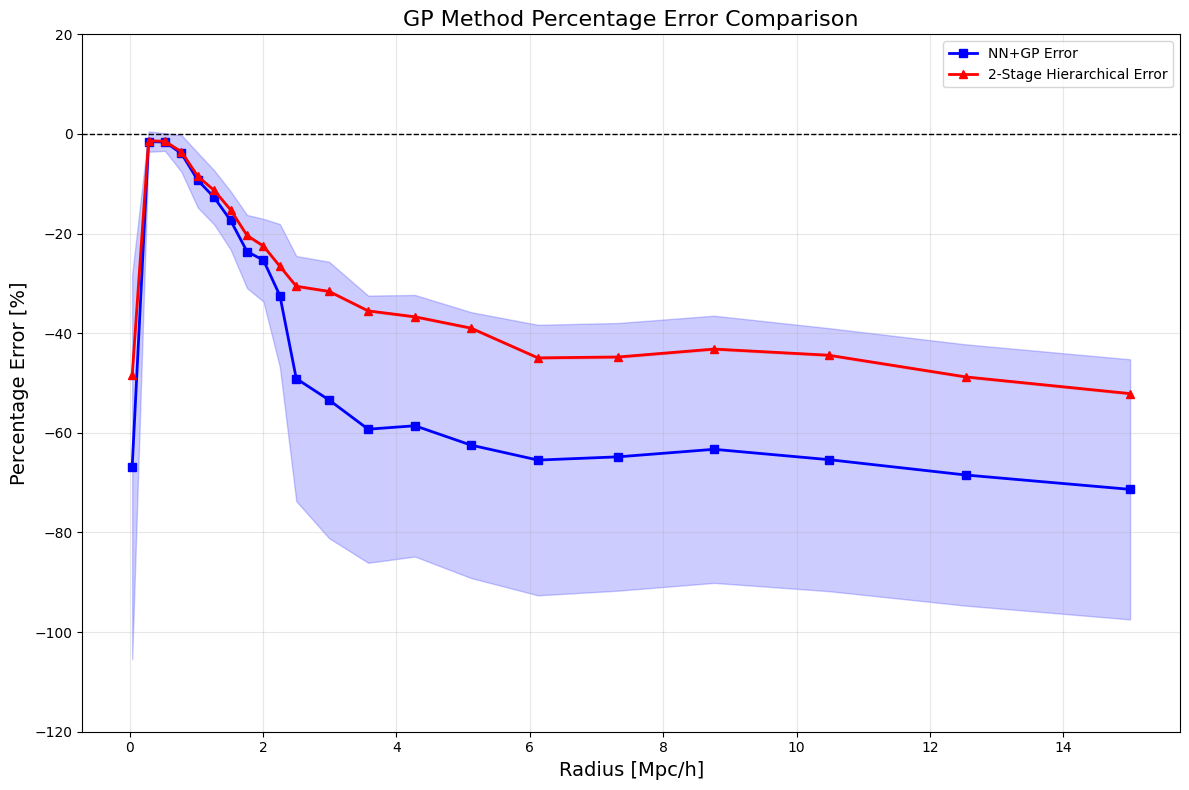

In [16]:
# Create percentage error comparison plot
plt.figure(figsize=(12, 8))

# Helper function for percentage error
def compute_percentage_error(pred_means, pred_vars, label, color, marker='o'):
    median_pred = np.mean(pred_means, axis=1)
    percent_error = 100 * (median_pred - median) / median
    
    plt.plot(r_bins, percent_error, marker=marker, linestyle='-', 
             color=color, linewidth=2, markersize=6, label=f'{label} Error')
    
    # Add uncertainty bands
    uncertainty = np.mean(np.sqrt(pred_vars), axis=1)
    error_upper = 100 * (median_pred + uncertainty - median) / median
    error_lower = 100 * (median_pred - uncertainty - median) / median
    
    plt.fill_between(r_bins, error_lower, error_upper, color=color, alpha=0.2)
    
    return percent_error

# Plot errors for all methods
error_nn = compute_percentage_error(pred_means_nn, pred_vars_nn, 'NN+GP', 'blue', 's')
error_hier = compute_percentage_error(pred_means_hier, pred_vars_hier, '2-Stage Hierarchical', 'red', '^')

# Plot kernel errors
markers = ['v', '<', '>', 'p']
for i, (kernel_name, results) in enumerate(kernel_results.items()):
    if 'error' not in results:
        compute_percentage_error(results['pred_means'], results['pred_vars'], 
                               f'{kernel_name} GP', kernel_colors[i % len(kernel_colors)], 
                               markers[i % len(markers)])

plt.axhline(0, color='k', linestyle='--', linewidth=1)
plt.xlabel('Radius [Mpc/h]', fontsize=14)
plt.ylabel('Percentage Error [%]', fontsize=14)
plt.ylim([-120,20])
plt.title('GP Method Percentage Error Comparison', fontsize=16)
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(f'{save_dir}/{plot_mode}_percentage_error_comparison.png', dpi=150, bbox_inches='tight')
plt.show()

## Summary Statistics

In [ ]:
# Compute summary metrics
def compute_summary_metrics(pred_means, pred_vars, ground_truth, method_name):
    pred_median = np.mean(pred_means, axis=1)
    
    # Only use valid (non-NaN) data points
    valid_mask = ~(np.isnan(pred_median) | np.isnan(ground_truth))
    
    if not np.any(valid_mask):
        return f"{method_name}: No valid predictions"
    
    pred_valid = pred_median[valid_mask]
    gt_valid = ground_truth[valid_mask]
    
    # Compute metrics
    mse = np.mean((pred_valid - gt_valid)**2)
    mae = np.mean(np.abs(pred_valid - gt_valid))
    mape = np.mean(np.abs((pred_valid - gt_valid) / gt_valid)) * 100
    
    # High radius performance (last 5 bins)
    high_r_mask = valid_mask[-5:]
    if np.any(high_r_mask):
        high_r_mape = np.mean(np.abs((pred_median[-5:][high_r_mask] - ground_truth[-5:][high_r_mask]) / 
                                   ground_truth[-5:][high_r_mask])) * 100
    else:
        high_r_mape = np.nan
    
    return {
        'method': method_name,
        'mse': mse,
        'mae': mae,
        'mape': mape,
        'high_radius_mape': high_r_mape,
        'n_valid': np.sum(valid_mask)
    }

print("\n" + "="*70)
print("SUMMARY METRICS")
print("="*70)

# Compute metrics for all methods
all_metrics = []
all_metrics.append(compute_summary_metrics(pred_means_nn, pred_vars_nn, median, 'NN+GP (loaded)'))
all_metrics.append(compute_summary_metrics(pred_means_hier, pred_vars_hier, median, 'Hierarchical (loaded)'))


# Add kernel metrics
for kernel_name, results in kernel_results.items():
    if 'error' not in results:
        all_metrics.append(compute_summary_metrics(results['pred_means'], results['pred_vars'], 
                                                  median, f'{kernel_name} GP'))

print(f"{'Method':<20} {'Valid':<5} {'MSE':<10} {'MAE':<10} {'MAPE%':<8} {'HighR%':<8}")
print("-" * 75)

for metrics in all_metrics:
    if isinstance(metrics, dict):
        print(f"{metrics['method']:<20} {metrics['n_valid']:<5} "
              f"{metrics['mse']:<10.2e} {metrics['mae']:<10.2e} "
              f"{metrics['mape']:<8.1f} {metrics['high_radius_mape']:<8.1f}")
    else:
        print(metrics)


In [ ]:
# Save comprehensive summary data
summary = {
    'timestamp': datetime.now().isoformat(),
    'loading_training_times': dict(zip(methods, times)),
    'kernel_comparison_results': {
        kernel: {'train_time': results.get('train_time', None), 
                'pred_time': results.get('pred_time', None),
                'error': results.get('error', None)}
        for kernel, results in kernel_results.items()
    },
    'metrics': {
        metrics['method'].replace(' ', '_').replace('(', '').replace(')', '').replace('-', '_').lower(): 
        metrics if isinstance(metrics, dict) else {'error': str(metrics)}
        for metrics in all_metrics
    },
    'data_info': {
        'n_train_sims': len(sim_subset),
        'n_test_sims': len(sim_indices_test),
        'n_radius_bins': len(r_bins),
        'filter_type': 'CAP',
        'particle_type': 'gas',
        'pretrained_models_from': pretrained_dir
    }
}

import json
with open(f'{save_dir}/comparison_summary.json', 'w') as f:
    json.dump(summary, f, indent=2, default=str)

print(f"Comprehensive summary saved to: {save_dir}/{plot_mode}_comparison_summary.json")
print("\n✅ GP method comparison with different kernels complete!")